In [1]:
# Import and Set up
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates
from pandas.api.types import CategoricalDtype
from plotnine import ggplot, aes, geom_line
from plotnine import *
from pybaseball import statcast
from pybaseball import statcast_batter
from pybaseball import statcast_batter_exitvelo_barrels
from pybaseball import statcast_batter_expected_stats
from pybaseball import cache
cache.enable()

In [2]:
# GOAL
# Determine who the unluckiest hitters were in 2021 based on a variety of metrics
    ## Estimated statistics are applied to all batted ball events
    ## By calculating the difference in results vs the expected results we can determine who has been unlucky
    ## Find the players who have the most hard hit outs (95 mph+)


In [3]:
# Importing every single pitch from the 2021 season
df = statcast(start_dt='2021-01-01', end_dt='2022-01-01')

This is a large query, it may take a moment to complete
Skipping offseason dates
Skipping offseason dates


100%|█████████████████████████████████████████| 246/246 [01:35<00:00,  2.56it/s]


In [4]:
# Viewing the dataframe
pd.set_option('display.max_columns', None)
df.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
109,FF,2021-11-02,93.7,1.39,6.72,"Smith, Will",493329,519293,field_out,hit_into_play,<NA>,<NA>,<NA>,<NA>,5,"Yuli Gurriel grounds out, shortstop Dansby Swa...",W,R,L,HOU,ATL,X,6,ground_ball,0,2,2021,0.57,1.21,0.19,2.68,<NA>,<NA>,488726,2,9,Bot,98.12,136.43,<NA>,<NA>,518595,<NA>,<NA>,-4.348927,-136.263269,-7.335202,8.101619,29.384843,-15.743652,3.37,1.53,5,93.8,-28,93.4,2112,6.1,660906,519293,518595,518692,645277,663586,621020,592696,628338,594807,54.39,0.071,0.064,0.0,1,0,0,2,69,3,4-Seam Fastball,0,7,0,7,7,0,0,7,Standard,Standard,146,0.0,-0.138
121,FF,2021-11-02,92.9,1.38,6.72,"Smith, Will",493329,519293,None,foul,<NA>,<NA>,<NA>,<NA>,5,"Yuli Gurriel grounds out, shortstop Dansby Swa...",W,R,L,HOU,ATL,S,<NA>,None,0,1,2021,0.9,1.34,0.01,2.12,<NA>,<NA>,488726,2,9,Bot,<NA>,<NA>,<NA>,<NA>,518595,<NA>,<NA>,-5.455433,-134.989926,-8.881689,12.188852,30.69001,-14.009571,3.37,1.53,156,75.0,15,92.6,2206,6.3,660906,519293,518595,518692,645277,663586,621020,592696,628338,594807,54.22,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,69,2,4-Seam Fastball,0,7,0,7,7,0,0,7,Standard,Standard,145,0.0,-0.047
125,FF,2021-11-02,93.1,1.35,6.73,"Smith, Will",493329,519293,None,called_strike,<NA>,<NA>,<NA>,<NA>,6,"Yuli Gurriel grounds out, shortstop Dansby Swa...",W,R,L,HOU,ATL,S,<NA>,None,0,0,2021,0.81,1.52,0.78,2.13,<NA>,<NA>,488726,2,9,Bot,<NA>,<NA>,<NA>,<NA>,518595,<NA>,<NA>,-3.230974,-135.201801,-9.255781,10.67848,31.699974,-11.7058,3.4,1.53,<NA>,<NA>,<NA>,92.5,2216,6.2,660906,519293,518595,518692,645277,663586,621020,592696,628338,594807,54.3,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,69,1,4-Seam Fastball,0,7,0,7,7,0,0,7,Standard,Standard,143,0.0,-0.042
131,FF,2021-11-02,94.6,1.31,6.73,"Smith, Will",670541,519293,field_out,hit_into_play,<NA>,<NA>,<NA>,<NA>,5,Yordan Alvarez flies out to left fielder Eddie...,W,L,L,HOU,ATL,X,7,fly_ball,3,2,2021,0.85,1.27,-0.23,2.66,<NA>,<NA>,488726,1,9,Bot,68.5,86.79,<NA>,<NA>,518595,<NA>,<NA>,-5.901934,-137.422092,-7.652311,12.118242,35.102245,-14.577857,3.58,1.68,312,92.7,39,93.8,2263,6.3,660906,519293,518595,518692,645277,663586,621020,592696,628338,594807,54.25,0.026,0.046,0.0,1,0,0,3,68,6,4-Seam Fastball,0,7,0,7,7,0,0,7,Infield shift,Standard,140,-0.001,-0.386
142,FF,2021-11-02,93.6,1.31,6.8,"Smith, Will",670541,519293,None,ball,<NA>,<NA>,<NA>,<NA>,13,Yordan Alvarez flies out to left fielder Eddie...,W,L,L,HOU,ATL,B,<NA>,None,2,2,2021,0.9,1.43,-1.15,1.51,<NA>,<NA>,488726,1,9,Bot,<NA>,<NA>,<NA>,<NA>,518595,<NA>,<NA>,-8.265487,-135.578023,-10.936295,12.932808,31.370147,-12.168466,3.46,1.68,<NA>,<NA>,<NA>,92.8,2239,6.2,660906,519293,518595,518692,645277,663586,621020,592696,628338,594807,54.28,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,68,5,4-Seam Fastball,0,7,0,7,7,0,0,7,Infield shift,Standard,152,0.0,0.12


In [5]:
# Remove spring training games and playoffs
df = df[df.game_type != 'S']
df = df[df.game_type != 'F']
df = df[df.game_type != 'L']
df = df[df.game_type != 'D']
df = df[df.game_type != 'W']
df = df[df.game_type != 'E']

In [6]:
# Looking for the player with the most hard hit (95 mph+) outs in 2021
df[(df['launch_speed'] >= 95) & (df['events'].str.contains('out|play|sac|choice', regex=True))].batter.value_counts().head(10)

592518    134
665489    127
518934    125
621566    125
521692    121
502671    118
666182    115
467793    114
592450    112
646240    112
Name: batter, dtype: Int64

In [7]:
# Importing a dataset to find player names that match player_id's
barrels = statcast_batter_exitvelo_barrels(2021, 100)
barrels.sort_values('barrels', ascending=False)

,last_name,first_name,player_id,attempts,avg_hit_angle,anglesweetspotpercent,max_hit_speed,avg_hit_speed,fbld,gb,max_distance,avg_distance,avg_hr_distance,ev95plus,ev95percent,barrels,brl_percent,brl_pa
118,Ohtani,Shohei,660271,350,16.6,35.4,119.0,93.6,100.4,85.9,470,197,416.0,187,53.6,78,22.3,12.2
13,Guerrero Jr.,Vladimir,665489,496,9.4,33.7,117.4,95.1,98.5,93.4,465,172,409.0,274,55.2,75,15.1,10.7
28,Perez,Salvador,521692,454,15.9,34.1,114.4,93.0,97.6,88.8,460,189,407.0,255,56.2,74,16.3,11.1
72,Judge,Aaron,592450,397,11.6,38.5,119.0,95.8,98.5,93.3,455,185,402.0,230,58.4,70,17.6,11.1
138,Tatis Jr.,Fernando,665487,329,13.8,33.1,116.6,93.9,99.9,87.9,477,184,416.0,183,55.6,70,21.3,12.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382,Hernandez,Yonny,660634,113,4.1,36.3,106.3,83.1,85.8,81.3,391,128,NaN,18,15.9,1,0.9,0.6
391,Locastro,Tim,641796,107,14.3,31.8,107.1,82.1,85.1,79.4,395,154,366.0,18,16.8,1,0.9,0.6
310,Sierra,Magneuris,642423,160,7.7,25.6,103.1,82.3,83.2,85.0,348,122,NaN,30,18.8,0,0.0,0.0
390,Nogowski,John,596056,108,15.6,38.0,108.1,88.1,90.9,85.2,387,183,387.0,31,28.7,0,0.0,0.0


In [8]:
# Merging the datasets to get batter names instead of ID's
merged = df.merge(barrels,left_on='batter', right_on='player_id')

In [9]:
# Looking at merged dataframe
merged.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,last_name,first_name,player_id,attempts,avg_hit_angle,anglesweetspotpercent,max_hit_speed,avg_hit_speed,fbld,gb,max_distance,avg_distance,avg_hr_distance,ev95plus,ev95percent,barrels,brl_percent,brl_pa
0,FF,2021-10-03,92.3,1.4,6.8,"Smith, Will",596019,519293,field_out,hit_into_play,<NA>,<NA>,<NA>,<NA>,1,"Francisco Lindor grounds out, third baseman Eh...",R,R,L,ATL,NYM,X,5,ground_ball,1,2,2021,0.69,1.38,-0.69,2.83,<NA>,<NA>,<NA>,2,9,Top,77.54,155.31,<NA>,<NA>,518595,<NA>,<NA>,-6.833043,-134.166485,-7.361843,9.708393,26.562803,-14.083224,3.32,1.51,13,95.2,-13,92.8,2330,6.5,632254,519293,518595,663586,645277,501303,606115,592696,628338,594807,54.03,0.174,0.158,0.0,1,0,0,2,61,4,4-Seam Fastball,5,0,0,5,0,5,0,5,Infield shift,Strategic,148,0.0,-0.073,Lindor,Francisco,596019,365,14.4,35.3,112.9,90.7,94.0,88.3,436,172,396.0,161,44.1,30,8.2,5.7
1,SL,2021-10-03,80.6,1.6,6.64,"Smith, Will",596019,519293,None,foul,<NA>,<NA>,<NA>,<NA>,4,"Francisco Lindor grounds out, third baseman Eh...",R,R,L,ATL,NYM,S,<NA>,None,1,1,2021,-0.77,0.48,-0.71,2.62,<NA>,<NA>,<NA>,2,9,Top,<NA>,<NA>,<NA>,<NA>,518595,<NA>,<NA>,-3.700232,-117.430885,-3.266842,-6.531123,19.79339,-27.369114,3.32,1.51,108,75.3,75,81.2,2254,6.4,632254,519293,518595,663586,645277,501303,606115,592696,628338,594807,54.15,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,61,3,Slider,5,0,0,5,0,5,0,5,Infield shift,Strategic,315,0.0,-0.027,Lindor,Francisco,596019,365,14.4,35.3,112.9,90.7,94.0,88.3,436,172,396.0,161,44.1,30,8.2,5.7
2,CU,2021-10-03,75.5,1.46,6.88,"Smith, Will",596019,519293,None,foul,<NA>,<NA>,<NA>,<NA>,5,"Francisco Lindor grounds out, third baseman Eh...",R,R,L,ATL,NYM,S,<NA>,None,1,0,2021,-0.65,-0.51,-0.04,2.46,<NA>,<NA>,<NA>,2,9,Top,<NA>,<NA>,<NA>,<NA>,518595,<NA>,<NA>,-1.977183,-109.901781,-1.155694,-4.872924,20.602334,-36.262184,3.32,1.51,157,83.5,65,75.2,1940,6.2,632254,519293,518595,663586,645277,501303,606115,592696,628338,594807,54.34,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,61,2,Curveball,5,0,0,5,0,5,0,5,Infield shift,Standard,328,0.0,-0.02,Lindor,Francisco,596019,365,14.4,35.3,112.9,90.7,94.0,88.3,436,172,396.0,161,44.1,30,8.2,5.7
3,CU,2021-10-03,75.0,1.53,6.83,"Smith, Will",596019,519293,None,ball,<NA>,<NA>,<NA>,<NA>,12,"Francisco Lindor grounds out, third baseman Eh...",R,R,L,ATL,NYM,B,<NA>,None,0,0,2021,-0.69,-0.69,2.1,3.89,<NA>,<NA>,<NA>,2,9,Top,<NA>,<NA>,<NA>,<NA>,518595,<NA>,<NA>,2.37583,-109.20583,2.277617,-5.902656,19.427562,-38.284747,3.31,1.48,<NA>,<NA>,<NA>,74.5,2017,5.9,632254,519293,518595,663586,645277,501303,606115,592696,628338,594807,54.61,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,61,1,Curveball,5,0,0,5,0,5,0,5,Standard,Standard,330,0.0,0.016,Lindor,Francisco,596019,365,14.4,35.3,112.9,90.7,94.0,88.3,436,172,396.0,161,44.1,30,8.2,5.7
4,CU,2021-10-03,84.2,-2.45,6.4,"Jackson, Luke",596019,592426,field_out,hit_into_play,<NA>,<NA>,<NA>,<NA>,13,Francisco Lindor flies out to left fielder Edd...,R,L,R,ATL,NYM,X,7,fly_ball,0,0,2021,0.5,-1.07,-1.13,1.48,<NA>,<NA>,<NA>,2,

In [10]:
# Renaming first name column to get rid of the empty space
merged = merged.rename(columns={' first_name':'first_name'})

In [11]:
# Converting first and last name columns into one batter name column
merged['batter_name']= merged['first_name'] + ' ' + merged['last_name']

In [12]:
# Changing attempts to bbe (batted ball events)
merged = merged.rename(columns={'attempts':'bbe'})

In [13]:
# Removing foul balls because they do not count towards batted ball events
merged = merged[merged.description != 'foul']

In [14]:
ab = merged[merged['events'].str.contains('out|single|double|triple|run|fielders|error', regex=True, na=False)].batter_name.value_counts().to_frame(name='ab')

In [15]:
ab = ab.reset_index()
ab = ab.rename(columns={'index': 'batter_name'})

In [16]:
merged.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,last_name,first_name,player_id,bbe,avg_hit_angle,anglesweetspotpercent,max_hit_speed,avg_hit_speed,fbld,gb,max_distance,avg_distance,avg_hr_distance,ev95plus,ev95percent,barrels,brl_percent,brl_pa,batter_name
0,FF,2021-10-03,92.3,1.4,6.8,"Smith, Will",596019,519293,field_out,hit_into_play,<NA>,<NA>,<NA>,<NA>,1,"Francisco Lindor grounds out, third baseman Eh...",R,R,L,ATL,NYM,X,5,ground_ball,1,2,2021,0.69,1.38,-0.69,2.83,<NA>,<NA>,<NA>,2,9,Top,77.54,155.31,<NA>,<NA>,518595,<NA>,<NA>,-6.833043,-134.166485,-7.361843,9.708393,26.562803,-14.083224,3.32,1.51,13,95.2,-13,92.8,2330,6.5,632254,519293,518595,663586,645277,501303,606115,592696,628338,594807,54.03,0.174,0.158,0.0,1,0,0,2,61,4,4-Seam Fastball,5,0,0,5,0,5,0,5,Infield shift,Strategic,148,0.0,-0.073,Lindor,Francisco,596019,365,14.4,35.3,112.9,90.7,94.0,88.3,436,172,396.0,161,44.1,30,8.2,5.7,Francisco Lindor
3,CU,2021-10-03,75.0,1.53,6.83,"Smith, Will",596019,519293,None,ball,<NA>,<NA>,<NA>,<NA>,12,"Francisco Lindor grounds out, third baseman Eh...",R,R,L,ATL,NYM,B,<NA>,None,0,0,2021,-0.69,-0.69,2.1,3.89,<NA>,<NA>,<NA>,2,9,Top,<NA>,<NA>,<NA>,<NA>,518595,<NA>,<NA>,2.37583,-109.20583,2.277617,-5.902656,19.427562,-38.284747,3.31,1.48,<NA>,<NA>,<NA>,74.5,2017,5.9,632254,519293,518595,663586,645277,501303,606115,592696,628338,594807,54.61,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,61,1,Curveball,5,0,0,5,0,5,0,5,Standard,Standard,330,0.0,0.016,Lindor,Francisco,596019,365,14.4,35.3,112.9,90.7,94.0,88.3,436,172,396.0,161,44.1,30,8.2,5.7,Francisco Lindor
4,CU,2021-10-03,84.2,-2.45,6.4,"Jackson, Luke",596019,592426,field_out,hit_into_play,<NA>,<NA>,<NA>,<NA>,13,Francisco Lindor flies out to left fielder Edd...,R,L,R,ATL,NYM,X,7,fly_ball,0,0,2021,0.5,-1.07,-1.13,1.48,<NA>,<NA>,<NA>,2,6,Top,75.23,129.38,<NA>,<NA>,518595,<NA>,<NA>,2.103044,-122.604777,-2.919163,4.62277,24.810148,-42.591369,3.32,1.51,215,71.3,44,84.8,2295,6.7,632254,592426,518595,663586,645277,501303,621020,592696,594807,624585,53.78,0.306,0.307,0.0,1,0,0,3,43,1,Curveball,5,0,0,5,0,5,0,5,Standard,Standard,29,0.003,-0.103,Lindor,Francisco,596019,365,14.4,35.3,112.9,90.7,94.0,88.3,436,172,396.0,161,44.1,30,8.2,5.7,Francisco Lindor
5,FF,2021-10-03,98.6,-1.74,5.81,"Strider, Spencer",596019,675911,field_out,hit_into_play,<NA>,<NA>,<NA>,<NA>,2,Francisco Lindor pops out to first baseman Fre...,R,L,R,ATL,NYM,X,3,popup,3,2,2021,-0.41,1.48,0.23,3.32,<NA>,<NA>,<NA>,0,4,Top,144.47,159.32,<NA>,<NA>,518595,<NA>,<NA>,6.364085,-143.457922,-4.757415,-7.143219,33.967873,-10.891418,3.32,1.51,115,92.0,67,99.3,2356,6.7,632254,675911,518595,518692,645277,663586,621020,592696,594807,624585,53.75,0.006,0.005,0.0,1,0,0,3,26,7,4-Seam Fastball,5,0,0,5,0,5,0,5,Standard,Standard,205,0.011,-0.318,Lindor,Francisco,596019,365,14.4,35.3,112.9,90.7,94.0,88.3,436,172,396.0,161,44.1,30,8.2,5.7,Francisco Lindor
7,FF,2021-10-03,97.3,-1.78,5.87,"Strider, Spencer",596019,675911,None,swinging_strike,<NA>,<NA>,<NA>,<NA>,1,Francisco Lindor pops out to first 

In [17]:
merged = merged.merge(ab, left_on='batter_name', right_on='batter_name')
merged.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,last_name,first_name,player_id,bbe,avg_hit_angle,anglesweetspotpercent,max_hit_speed,avg_hit_speed,fbld,gb,max_distance,avg_distance,avg_hr_distance,ev95plus,ev95percent,barrels,brl_percent,brl_pa,batter_name,ab
0,FF,2021-10-03,92.3,1.4,6.8,"Smith, Will",596019,519293,field_out,hit_into_play,<NA>,<NA>,<NA>,<NA>,1,"Francisco Lindor grounds out, third baseman Eh...",R,R,L,ATL,NYM,X,5,ground_ball,1,2,2021,0.69,1.38,-0.69,2.83,<NA>,<NA>,<NA>,2,9,Top,77.54,155.31,<NA>,<NA>,518595,<NA>,<NA>,-6.833043,-134.166485,-7.361843,9.708393,26.562803,-14.083224,3.32,1.51,13,95.2,-13,92.8,2330,6.5,632254,519293,518595,663586,645277,501303,606115,592696,628338,594807,54.03,0.174,0.158,0.0,1,0,0,2,61,4,4-Seam Fastball,5,0,0,5,0,5,0,5,Infield shift,Strategic,148,0.0,-0.073,Lindor,Francisco,596019,365,14.4,35.3,112.9,90.7,94.0,88.3,436,172,396.0,161,44.1,30,8.2,5.7,Francisco Lindor,452
1,CU,2021-10-03,75.0,1.53,6.83,"Smith, Will",596019,519293,None,ball,<NA>,<NA>,<NA>,<NA>,12,"Francisco Lindor grounds out, third baseman Eh...",R,R,L,ATL,NYM,B,<NA>,None,0,0,2021,-0.69,-0.69,2.1,3.89,<NA>,<NA>,<NA>,2,9,Top,<NA>,<NA>,<NA>,<NA>,518595,<NA>,<NA>,2.37583,-109.20583,2.277617,-5.902656,19.427562,-38.284747,3.31,1.48,<NA>,<NA>,<NA>,74.5,2017,5.9,632254,519293,518595,663586,645277,501303,606115,592696,628338,594807,54.61,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,61,1,Curveball,5,0,0,5,0,5,0,5,Standard,Standard,330,0.0,0.016,Lindor,Francisco,596019,365,14.4,35.3,112.9,90.7,94.0,88.3,436,172,396.0,161,44.1,30,8.2,5.7,Francisco Lindor,452
2,CU,2021-10-03,84.2,-2.45,6.4,"Jackson, Luke",596019,592426,field_out,hit_into_play,<NA>,<NA>,<NA>,<NA>,13,Francisco Lindor flies out to left fielder Edd...,R,L,R,ATL,NYM,X,7,fly_ball,0,0,2021,0.5,-1.07,-1.13,1.48,<NA>,<NA>,<NA>,2,6,Top,75.23,129.38,<NA>,<NA>,518595,<NA>,<NA>,2.103044,-122.604777,-2.919163,4.62277,24.810148,-42.591369,3.32,1.51,215,71.3,44,84.8,2295,6.7,632254,592426,518595,663586,645277,501303,621020,592696,594807,624585,53.78,0.306,0.307,0.0,1,0,0,3,43,1,Curveball,5,0,0,5,0,5,0,5,Standard,Standard,29,0.003,-0.103,Lindor,Francisco,596019,365,14.4,35.3,112.9,90.7,94.0,88.3,436,172,396.0,161,44.1,30,8.2,5.7,Francisco Lindor,452
3,FF,2021-10-03,98.6,-1.74,5.81,"Strider, Spencer",596019,675911,field_out,hit_into_play,<NA>,<NA>,<NA>,<NA>,2,Francisco Lindor pops out to first baseman Fre...,R,L,R,ATL,NYM,X,3,popup,3,2,2021,-0.41,1.48,0.23,3.32,<NA>,<NA>,<NA>,0,4,Top,144.47,159.32,<NA>,<NA>,518595,<NA>,<NA>,6.364085,-143.457922,-4.757415,-7.143219,33.967873,-10.891418,3.32,1.51,115,92.0,67,99.3,2356,6.7,632254,675911,518595,518692,645277,663586,621020,592696,594807,624585,53.75,0.006,0.005,0.0,1,0,0,3,26,7,4-Seam Fastball,5,0,0,5,0,5,0,5,Standard,Standard,205,0.011,-0.318,Lindor,Francisco,596019,365,14.4,35.3,112.9,90.7,94.0,88.3,436,172,396.0,161,44.1,30,8.2,5.7,Francisco Lindor,452
4,FF,2021-10-03,97.3,-1.78,5.87,"Strider, Spencer",596019,675911,None,swinging_strike,<NA>,<NA>,<NA>,<NA>,1,Francisco Lindor

In [18]:
# Creating new dataframe of only hard hit balls (95 mph+)
hh = merged[(merged['launch_speed'] >= 95)]

In [19]:
# Players with the most hard hit balls
hh.batter_name.value_counts().head(10)

 Vladimir Guerrero Jr.    274
 Salvador Perez           255
 Manny Machado            247
 Bo Bichette              241
 Paul Goldschmidt         239
 Rafael Devers            234
 Aaron Judge              230
 Freddie Freeman          228
 Trea Turner              226
 Matt Olson               226
Name: batter_name, dtype: int64

In [20]:
# Looking for the top 5 players with the most hard hit outs
hh[hh['events'].str.contains('out|play|sac|choice', regex=True)].batter_name.value_counts().head(5).to_frame(name='hho')

,hho
Manny Machado,134
Vladimir Guerrero Jr.,127
Matt Olson,125
DJ LeMahieu,125
Salvador Perez,121


In [21]:
# Taking the hard hit out value counts and converting it to a dataframe to merge with the original dataframe
hh_outs = hh[hh['events'].str.contains('out|play|sac|choice', regex=True)].batter_name.value_counts().to_frame()
hh_outs = hh_outs.reset_index()
hh_outs = hh_outs.rename(columns={'index':'name', "batter_name":'hho'})
hh_outs.columns

Index(['name', 'hho'], dtype='object')

In [22]:
# Merging the dataframes
hh = hh.merge(hh_outs,left_on='batter_name', right_on='name')
hh.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,last_name,first_name,player_id,bbe,avg_hit_angle,anglesweetspotpercent,max_hit_speed,avg_hit_speed,fbld,gb,max_distance,avg_distance,avg_hr_distance,ev95plus,ev95percent,barrels,brl_percent,brl_pa,batter_name,ab,name,hho
0,FF,2021-10-03,92.3,1.4,6.8,"Smith, Will",596019,519293,field_out,hit_into_play,<NA>,<NA>,<NA>,<NA>,1,"Francisco Lindor grounds out, third baseman Eh...",R,R,L,ATL,NYM,X,5,ground_ball,1,2,2021,0.69,1.38,-0.69,2.83,<NA>,<NA>,<NA>,2,9,Top,77.54,155.31,<NA>,<NA>,518595,<NA>,<NA>,-6.833043,-134.166485,-7.361843,9.708393,26.562803,-14.083224,3.32,1.51,13,95.2,-13,92.8,2330,6.5,632254,519293,518595,663586,645277,501303,606115,592696,628338,594807,54.03,0.174,0.158,0.0,1,0,0,2,61,4,4-Seam Fastball,5,0,0,5,0,5,0,5,Infield shift,Strategic,148,0.0,-0.073,Lindor,Francisco,596019,365,14.4,35.3,112.9,90.7,94.0,88.3,436,172,396.0,161,44.1,30,8.2,5.7,Francisco Lindor,452,Francisco Lindor,92
1,FF,2021-10-02,92.3,-2.96,6.02,"Rodríguez, Richard",596019,593144,field_out,hit_into_play,<NA>,<NA>,<NA>,<NA>,11,Francisco Lindor flies out to center fielder G...,R,L,R,ATL,NYM,X,8,fly_ball,1,2,2021,-1.01,1.31,-0.63,3.51,<NA>,<NA>,607043,1,9,Top,130.05,59.56,<NA>,<NA>,661388,<NA>,<NA>,8.151816,-134.073837,-3.394352,-14.0032,31.483269,-15.842442,3.32,1.51,380,101.3,31,92.3,2329,6.6,632262,593144,661388,518692,606115,501303,621020,592696,628338,592626,53.91,0.651,1.259,0.0,1,0,0,6,75,6,4-Seam Fastball,6,5,5,6,5,6,5,6,Standard,Standard,221,0.091,-0.217,Lindor,Francisco,596019,365,14.4,35.3,112.9,90.7,94.0,88.3,436,172,396.0,161,44.1,30,8.2,5.7,Francisco Lindor,452,Francisco Lindor,92
2,FF,2021-09-30,89.1,-1.55,5.11,"Madero, Luís",596019,650347,home_run,hit_into_play,<NA>,<NA>,<NA>,<NA>,8,Francisco Lindor hits a grand slam (20) to rig...,R,L,R,NYM,MIA,X,<NA>,fly_ball,0,0,2021,-0.94,0.84,-0.21,1.85,643446,542340,607043,2,8,Bot,212.13,61.64,<NA>,<NA>,663743,<NA>,<NA>,5.305486,-129.510373,-3.692962,-11.676192,30.182592,-22.148722,3.32,1.51,399,109.6,24,89.4,2333,6.8,632283,650347,663743,650331,665862,657193,500743,621446,642423,650559,53.72,0.986,1.918,2.0,1,0,3,6,72,1,4-Seam Fastball,6,3,6,3,3,10,10,3,Strategic,Strategic,228,0.022,3.278,Lindor,Francisco,596019,365,14.4,35.3,112.9,90.7,94.0,88.3,436,172,396.0,161,44.1,30,8.2,5.7,Francisco Lindor,452,Francisco Lindor,92
3,SI,2021-09-29,90.2,3.3,5.99,"Bleier, Richard",596019,542947,single,hit_into_play,<NA>,<NA>,<NA>,<NA>,9,Francisco Lindor singles on a sharp line drive...,R,R,L,NYM,MIA,X,9,line_drive,1,2,2021,1.3,0.16,0.34,1.98,<NA>,<NA>,<NA>,2,8,Bot,160.21,129.13,<NA>,<NA>,663743,<NA>,<NA>,-10.114527,-130.885175,-4.287424,17.078775,28.770432,-29.564809,3.32,1.51,198,103.0,9,90.0,1893,6.4,632303,542947,663743,650331,665862,657193,500743,621446,650559,660821,54.07,0.749,0.706,0.9,1,1,0,4,57,4,Sinker,2,3,2,3,3,2,2,3,Standard,Standard,129,0.037,0.152,Lindor,Francisco,596019,365,14.4,35.3,112.9,90.7,94.0,88.3,436,172,396.0,161,44.1,30,8.2,5.7,Francisco Lindor,452,Francisco Lindor,92

In [23]:
# Removing duplicate column name
hh = hh.drop(columns={'name'}, axis=1)
hh.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,last_name,first_name,player_id,bbe,avg_hit_angle,anglesweetspotpercent,max_hit_speed,avg_hit_speed,fbld,gb,max_distance,avg_distance,avg_hr_distance,ev95plus,ev95percent,barrels,brl_percent,brl_pa,batter_name,ab,hho
0,FF,2021-10-03,92.3,1.4,6.8,"Smith, Will",596019,519293,field_out,hit_into_play,<NA>,<NA>,<NA>,<NA>,1,"Francisco Lindor grounds out, third baseman Eh...",R,R,L,ATL,NYM,X,5,ground_ball,1,2,2021,0.69,1.38,-0.69,2.83,<NA>,<NA>,<NA>,2,9,Top,77.54,155.31,<NA>,<NA>,518595,<NA>,<NA>,-6.833043,-134.166485,-7.361843,9.708393,26.562803,-14.083224,3.32,1.51,13,95.2,-13,92.8,2330,6.5,632254,519293,518595,663586,645277,501303,606115,592696,628338,594807,54.03,0.174,0.158,0.0,1,0,0,2,61,4,4-Seam Fastball,5,0,0,5,0,5,0,5,Infield shift,Strategic,148,0.0,-0.073,Lindor,Francisco,596019,365,14.4,35.3,112.9,90.7,94.0,88.3,436,172,396.0,161,44.1,30,8.2,5.7,Francisco Lindor,452,92
1,FF,2021-10-02,92.3,-2.96,6.02,"Rodríguez, Richard",596019,593144,field_out,hit_into_play,<NA>,<NA>,<NA>,<NA>,11,Francisco Lindor flies out to center fielder G...,R,L,R,ATL,NYM,X,8,fly_ball,1,2,2021,-1.01,1.31,-0.63,3.51,<NA>,<NA>,607043,1,9,Top,130.05,59.56,<NA>,<NA>,661388,<NA>,<NA>,8.151816,-134.073837,-3.394352,-14.0032,31.483269,-15.842442,3.32,1.51,380,101.3,31,92.3,2329,6.6,632262,593144,661388,518692,606115,501303,621020,592696,628338,592626,53.91,0.651,1.259,0.0,1,0,0,6,75,6,4-Seam Fastball,6,5,5,6,5,6,5,6,Standard,Standard,221,0.091,-0.217,Lindor,Francisco,596019,365,14.4,35.3,112.9,90.7,94.0,88.3,436,172,396.0,161,44.1,30,8.2,5.7,Francisco Lindor,452,92
2,FF,2021-09-30,89.1,-1.55,5.11,"Madero, Luís",596019,650347,home_run,hit_into_play,<NA>,<NA>,<NA>,<NA>,8,Francisco Lindor hits a grand slam (20) to rig...,R,L,R,NYM,MIA,X,<NA>,fly_ball,0,0,2021,-0.94,0.84,-0.21,1.85,643446,542340,607043,2,8,Bot,212.13,61.64,<NA>,<NA>,663743,<NA>,<NA>,5.305486,-129.510373,-3.692962,-11.676192,30.182592,-22.148722,3.32,1.51,399,109.6,24,89.4,2333,6.8,632283,650347,663743,650331,665862,657193,500743,621446,642423,650559,53.72,0.986,1.918,2.0,1,0,3,6,72,1,4-Seam Fastball,6,3,6,3,3,10,10,3,Strategic,Strategic,228,0.022,3.278,Lindor,Francisco,596019,365,14.4,35.3,112.9,90.7,94.0,88.3,436,172,396.0,161,44.1,30,8.2,5.7,Francisco Lindor,452,92
3,SI,2021-09-29,90.2,3.3,5.99,"Bleier, Richard",596019,542947,single,hit_into_play,<NA>,<NA>,<NA>,<NA>,9,Francisco Lindor singles on a sharp line drive...,R,R,L,NYM,MIA,X,9,line_drive,1,2,2021,1.3,0.16,0.34,1.98,<NA>,<NA>,<NA>,2,8,Bot,160.21,129.13,<NA>,<NA>,663743,<NA>,<NA>,-10.114527,-130.885175,-4.287424,17.078775,28.770432,-29.564809,3.32,1.51,198,103.0,9,90.0,1893,6.4,632303,542947,663743,650331,665862,657193,500743,621446,650559,660821,54.07,0.749,0.706,0.9,1,1,0,4,57,4,Sinker,2,3,2,3,3,2,2,3,Standard,Standard,129,0.037,0.152,Lindor,Francisco,596019,365,14.4,35.3,112.9,90.7,94.0,88.3,436,172,396.0,161,44.1,30,8.2,5.7,Francisco Lindor,452,92
4,FF,2021-09-29,91.4,-1.85,5.37,"Hernandez, Elieser",596019,622694,field

In [24]:
# Calculating the percentage of hard hit outs for each player
# Found by dividing the number of hard hit outs by all batted ball events
hh['hho/bbe'] = hh.hho/hh.bbe*100
hh.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,last_name,first_name,player_id,bbe,avg_hit_angle,anglesweetspotpercent,max_hit_speed,avg_hit_speed,fbld,gb,max_distance,avg_distance,avg_hr_distance,ev95plus,ev95percent,barrels,brl_percent,brl_pa,batter_name,ab,hho,hho/bbe
0,FF,2021-10-03,92.3,1.4,6.8,"Smith, Will",596019,519293,field_out,hit_into_play,<NA>,<NA>,<NA>,<NA>,1,"Francisco Lindor grounds out, third baseman Eh...",R,R,L,ATL,NYM,X,5,ground_ball,1,2,2021,0.69,1.38,-0.69,2.83,<NA>,<NA>,<NA>,2,9,Top,77.54,155.31,<NA>,<NA>,518595,<NA>,<NA>,-6.833043,-134.166485,-7.361843,9.708393,26.562803,-14.083224,3.32,1.51,13,95.2,-13,92.8,2330,6.5,632254,519293,518595,663586,645277,501303,606115,592696,628338,594807,54.03,0.174,0.158,0.0,1,0,0,2,61,4,4-Seam Fastball,5,0,0,5,0,5,0,5,Infield shift,Strategic,148,0.0,-0.073,Lindor,Francisco,596019,365,14.4,35.3,112.9,90.7,94.0,88.3,436,172,396.0,161,44.1,30,8.2,5.7,Francisco Lindor,452,92,25.205479
1,FF,2021-10-02,92.3,-2.96,6.02,"Rodríguez, Richard",596019,593144,field_out,hit_into_play,<NA>,<NA>,<NA>,<NA>,11,Francisco Lindor flies out to center fielder G...,R,L,R,ATL,NYM,X,8,fly_ball,1,2,2021,-1.01,1.31,-0.63,3.51,<NA>,<NA>,607043,1,9,Top,130.05,59.56,<NA>,<NA>,661388,<NA>,<NA>,8.151816,-134.073837,-3.394352,-14.0032,31.483269,-15.842442,3.32,1.51,380,101.3,31,92.3,2329,6.6,632262,593144,661388,518692,606115,501303,621020,592696,628338,592626,53.91,0.651,1.259,0.0,1,0,0,6,75,6,4-Seam Fastball,6,5,5,6,5,6,5,6,Standard,Standard,221,0.091,-0.217,Lindor,Francisco,596019,365,14.4,35.3,112.9,90.7,94.0,88.3,436,172,396.0,161,44.1,30,8.2,5.7,Francisco Lindor,452,92,25.205479
2,FF,2021-09-30,89.1,-1.55,5.11,"Madero, Luís",596019,650347,home_run,hit_into_play,<NA>,<NA>,<NA>,<NA>,8,Francisco Lindor hits a grand slam (20) to rig...,R,L,R,NYM,MIA,X,<NA>,fly_ball,0,0,2021,-0.94,0.84,-0.21,1.85,643446,542340,607043,2,8,Bot,212.13,61.64,<NA>,<NA>,663743,<NA>,<NA>,5.305486,-129.510373,-3.692962,-11.676192,30.182592,-22.148722,3.32,1.51,399,109.6,24,89.4,2333,6.8,632283,650347,663743,650331,665862,657193,500743,621446,642423,650559,53.72,0.986,1.918,2.0,1,0,3,6,72,1,4-Seam Fastball,6,3,6,3,3,10,10,3,Strategic,Strategic,228,0.022,3.278,Lindor,Francisco,596019,365,14.4,35.3,112.9,90.7,94.0,88.3,436,172,396.0,161,44.1,30,8.2,5.7,Francisco Lindor,452,92,25.205479
3,SI,2021-09-29,90.2,3.3,5.99,"Bleier, Richard",596019,542947,single,hit_into_play,<NA>,<NA>,<NA>,<NA>,9,Francisco Lindor singles on a sharp line drive...,R,R,L,NYM,MIA,X,9,line_drive,1,2,2021,1.3,0.16,0.34,1.98,<NA>,<NA>,<NA>,2,8,Bot,160.21,129.13,<NA>,<NA>,663743,<NA>,<NA>,-10.114527,-130.885175,-4.287424,17.078775,28.770432,-29.564809,3.32,1.51,198,103.0,9,90.0,1893,6.4,632303,542947,663743,650331,665862,657193,500743,621446,650559,660821,54.07,0.749,0.706,0.9,1,1,0,4,57,4,Sinker,2,3,2,3,3,2,2,3,Standard,Standard,129,0.037,0.152,Lindor,Francisco,596019,365,14.4,35.3,112.9,90.7,94.0,88.3,436,172,396.0,161,44.1,30,8.2,5.7,Francisco Lindor,452,92,25.205479
4,FF,2021-09-29,91.4,-1.

In [25]:
# Keeping the columns needed to plot
df = hh.loc[:,['batter_name', 'hho', 'bbe', 'hho/bbe', 'barrels', 'brl_percent', 'brl_pa', 'ev95plus', 'ev95percent', 'ab']]
df

,batter_name,hho,bbe,hho/bbe,barrels,brl_percent,brl_pa,ev95plus,ev95percent,ab
0,Francisco Lindor,92,365,25.205479,30,8.2,5.7,161,44.1,452
1,Francisco Lindor,92,365,25.205479,30,8.2,5.7,161,44.1,452
2,Francisco Lindor,92,365,25.205479,30,8.2,5.7,161,44.1,452
3,Francisco Lindor,92,365,25.205479,30,8.2,5.7,161,44.1,452
4,Francisco Lindor,92,365,25.205479,30,8.2,5.7,161,44.1,452
...,...,...,...,...,...,...,...,...,...,...
43502,Marcell Ozuna,34,142,23.943662,14,9.9,6.7,58,40.8,188
43503,Marcell Ozuna,34,142,23.943662,14,9.9,6.7,58,40.8,188
43504,Marcell Ozuna,34,142,23.943662,14,9.9,6.7,58,40.8,188
43505,Marcell Ozuna,34,142,23.943662,14,9.9,6.7,58,40.8,188


In [26]:
# Dropping duplicate rows to group by player
df = df.drop_duplicates()

In [27]:
df.sort_values('hho/bbe', ascending=False).head(10)

,batter_name,hho,bbe,hho/bbe,barrels,brl_percent,brl_pa,ev95plus,ev95percent,ab
10755,Josh Donaldson,100,351,28.490028,61,17.4,11.2,185,52.7,457
41572,Gregory Polanco,68,240,28.333333,23,9.6,6.0,116,48.3,336
16669,Manny Machado,134,473,28.329810,63,13.3,9.8,247,52.2,564
18723,Aaron Judge,112,397,28.211587,70,17.6,11.1,230,58.4,550
7915,Chad Pinder,43,153,28.104575,25,16.3,10.7,83,54.2,214
40991,Phillip Evans,45,161,27.950311,7,4.3,2.8,69,42.9,214
20267,Nelson Cruz,110,396,27.777778,54,13.6,9.2,208,52.5,514
31426,Josh Bell,109,400,27.250000,35,8.8,6.2,208,52.0,498
14416,Daniel Vogelbach,43,158,27.215190,13,8.2,5.0,77,48.7,215
8653,Matt Olson,125,463,26.997840,59,12.7,8.8,226,48.8,565


In [28]:
df.bbe.median()

254.0

In [29]:
# Setting a minimum requirement of 200 batted ball events to get rid of players with skewed results
df = df[df['bbe']>=254]

In [30]:
df.sort_values('hho', ascending=False).head(10)

,batter_name,hho,bbe,hho/bbe,barrels,brl_percent,brl_pa,ev95plus,ev95percent,ab
16669,Manny Machado,134,473,28.329810,63,13.3,9.8,247,52.2,564
27683,Vladimir Guerrero Jr.,127,496,25.604839,75,15.1,10.7,274,55.2,604
8653,Matt Olson,125,463,26.997840,59,12.7,8.8,226,48.8,565
37811,DJ LeMahieu,125,508,24.606299,19,3.7,2.8,220,43.5,597
10940,Salvador Perez,121,454,26.651982,74,16.3,11.1,255,56.2,620
22769,Paul Goldschmidt,118,472,25.000000,64,13.6,9.4,239,50.6,604
27442,Bo Bichette,115,507,22.682446,50,9.9,7.2,241,47.5,640
10256,Carlos Santana,114,468,24.358974,32,6.8,4.9,196,41.9,566
30305,Rafael Devers,112,452,24.778761,68,15.0,10.2,234,51.8,591
18723,Aaron Judge,112,397,28.211587,70,17.6,11.1,230,58.4,550


In [31]:
# Finding top 10 in hard hit out percentage by bbe
df.sort_values('hho/bbe', ascending=False).head(10)

,batter_name,hho,bbe,hho/bbe,barrels,brl_percent,brl_pa,ev95plus,ev95percent,ab
10755,Josh Donaldson,100,351,28.490028,61,17.4,11.2,185,52.7,457
16669,Manny Machado,134,473,28.329810,63,13.3,9.8,247,52.2,564
18723,Aaron Judge,112,397,28.211587,70,17.6,11.1,230,58.4,550
20267,Nelson Cruz,110,396,27.777778,54,13.6,9.2,208,52.5,514
31426,Josh Bell,109,400,27.250000,35,8.8,6.2,208,52.0,498
8653,Matt Olson,125,463,26.997840,59,12.7,8.8,226,48.8,565
10940,Salvador Perez,121,454,26.651982,74,16.3,11.1,255,56.2,620
7338,Yordan Alvarez,105,395,26.582278,63,15.9,10.5,214,54.2,537
32572,Miguel Cabrera,95,363,26.170799,30,8.3,5.7,178,49.0,472
16916,Fernando Tatis Jr.,86,329,26.139818,70,21.3,12.8,183,55.6,478


In [32]:
# Summing up all value counts for events to make a plate appearance (pa) column in the new dataframe
pd.set_option('display.max_rows', None)
pa = merged.groupby('batter_name').events.value_counts().to_frame(name='pa')
pa = pa.groupby('batter_name').pa.sum().to_frame()

In [33]:
# Merging the plate appearances
df = df.merge(pa,on='batter_name')
df

,batter_name,hho,bbe,hho/bbe,barrels,brl_percent,brl_pa,ev95plus,ev95percent,ab,pa
0,Francisco Lindor,92,365,25.205479,30,8.2,5.7,161,44.1,452,522
1,Adam Duvall,67,342,19.590643,55,16.1,9.9,150,43.9,513,555
2,Austin Riley,82,430,19.069767,57,13.3,8.6,196,45.6,590,660
3,Ozzie Albies,91,508,17.913386,47,9.3,6.9,189,37.2,630,684
4,Jonathan Villar,50,324,15.432099,24,7.4,4.8,113,34.9,454,503
5,Jorge Soler,90,379,23.746702,48,12.7,8.0,178,47.0,516,596
6,Dominic Smith,70,340,20.588235,22,6.5,4.5,138,40.7,446,492
7,Pete Alonso,102,438,23.287671,65,14.8,10.2,207,47.3,561,632
8,Michael Conforto,60,304,19.736842,28,9.2,5.8,120,39.5,407,478
9,Dansby Swanson,85,429,19.813520,49,11.4,7.5,183,42.7,588,649


In [34]:
# Finding hard hit outs per plate appearance
df['hho/pa'] = df.hho/df.pa*100
df

,batter_name,hho,bbe,hho/bbe,barrels,brl_percent,brl_pa,ev95plus,ev95percent,ab,pa,hho/pa
0,Francisco Lindor,92,365,25.205479,30,8.2,5.7,161,44.1,452,522,17.624521
1,Adam Duvall,67,342,19.590643,55,16.1,9.9,150,43.9,513,555,12.072072
2,Austin Riley,82,430,19.069767,57,13.3,8.6,196,45.6,590,660,12.424242
3,Ozzie Albies,91,508,17.913386,47,9.3,6.9,189,37.2,630,684,13.304094
4,Jonathan Villar,50,324,15.432099,24,7.4,4.8,113,34.9,454,503,9.940358
5,Jorge Soler,90,379,23.746702,48,12.7,8.0,178,47.0,516,596,15.100671
6,Dominic Smith,70,340,20.588235,22,6.5,4.5,138,40.7,446,492,14.227642
7,Pete Alonso,102,438,23.287671,65,14.8,10.2,207,47.3,561,632,16.139241
8,Michael Conforto,60,304,19.736842,28,9.2,5.8,120,39.5,407,478,12.552301
9,Dansby Swanson,85,429,19.813520,49,11.4,7.5,183,42.7,588,649,13.097072


In [35]:
df.sort_values('hho/pa', ascending=False).head(5)

,batter_name,hho,bbe,hho/bbe,barrels,brl_percent,brl_pa,ev95plus,ev95percent,ab,pa,hho/pa
89,Manny Machado,134,473,28.329810,63,13.3,9.8,247,52.2,564,631,21.236133
161,Josh Bell,109,400,27.250000,35,8.8,6.2,208,52.0,498,567,19.223986
108,Nelson Cruz,110,396,27.777778,54,13.6,9.2,208,52.5,514,573,19.197208
179,Harold Ramírez,69,286,24.125874,18,6.3,5.0,135,47.2,340,362,19.060773
45,Matt Olson,125,463,26.997840,59,12.7,8.8,226,48.8,565,661,18.910741


In [36]:
df.sort_values('hho/bbe', ascending=False).head(5)

,batter_name,hho,bbe,hho/bbe,barrels,brl_percent,brl_pa,ev95plus,ev95percent,ab,pa,hho/pa
57,Josh Donaldson,100,351,28.490028,61,17.4,11.2,185,52.7,457,541,18.484288
89,Manny Machado,134,473,28.329810,63,13.3,9.8,247,52.2,564,631,21.236133
99,Aaron Judge,112,397,28.211587,70,17.6,11.1,230,58.4,550,631,17.749604
108,Nelson Cruz,110,396,27.777778,54,13.6,9.2,208,52.5,514,573,19.197208
161,Josh Bell,109,400,27.250000,35,8.8,6.2,208,52.0,498,567,19.223986


In [37]:
# Importing expected statistics for the 2021 season
ex = statcast_batter_expected_stats(2021)
ex

,last_name,first_name,player_id,year,pa,bip,ba,est_ba,est_ba_minus_ba_diff,slg,est_slg,est_slg_minus_slg_diff,woba,est_woba,est_woba_minus_woba_diff
0,Semien,Marcus,543760,2021,724,509,0.265,0.245,0.020,0.538,0.455,0.083,0.368,0.333,0.035
1,Merrifield,Whit,593160,2021,720,573,0.277,0.263,0.014,0.395,0.383,0.012,0.306,0.301,0.005
2,Guerrero Jr.,Vladimir,665489,2021,698,496,0.311,0.307,0.004,0.601,0.594,0.007,0.419,0.418,0.001
3,Freeman,Freddie,518692,2021,695,495,0.300,0.320,-0.020,0.503,0.583,-0.080,0.379,0.416,-0.037
4,Edman,Tommy,669242,2021,691,552,0.262,0.274,-0.012,0.387,0.401,-0.014,0.301,0.316,-0.015
5,Haniger,Mitch,571745,2021,691,459,0.253,0.262,-0.009,0.485,0.497,-0.012,0.340,0.353,-0.013
6,Bichette,Bo,666182,2021,690,507,0.298,0.291,0.007,0.484,0.490,-0.006,0.354,0.355,-0.001
7,Crawford,J.P.,641487,2021,687,510,0.273,0.257,0.016,0.376,0.339,0.037,0.314,0.298,0.016
8,Albies,Ozzie,645277,2021,686,508,0.259,0.260,-0.001,0.488,0.465,0.023,0.336,0.332,0.004
9,LeMahieu,DJ,518934,2021,679,508,0.268,0.283,-0.015,0.362,0.397,-0.035,0.315,0.340,-0.025


In [38]:
# Making a full name column to merge with the other dataframe
ex['batter_name']= ex[' first_name'] + ' ' + ex['last_name']
ex

,last_name,first_name,player_id,year,pa,bip,ba,est_ba,est_ba_minus_ba_diff,slg,est_slg,est_slg_minus_slg_diff,woba,est_woba,est_woba_minus_woba_diff,batter_name
0,Semien,Marcus,543760,2021,724,509,0.265,0.245,0.020,0.538,0.455,0.083,0.368,0.333,0.035,Marcus Semien
1,Merrifield,Whit,593160,2021,720,573,0.277,0.263,0.014,0.395,0.383,0.012,0.306,0.301,0.005,Whit Merrifield
2,Guerrero Jr.,Vladimir,665489,2021,698,496,0.311,0.307,0.004,0.601,0.594,0.007,0.419,0.418,0.001,Vladimir Guerrero Jr.
3,Freeman,Freddie,518692,2021,695,495,0.300,0.320,-0.020,0.503,0.583,-0.080,0.379,0.416,-0.037,Freddie Freeman
4,Edman,Tommy,669242,2021,691,552,0.262,0.274,-0.012,0.387,0.401,-0.014,0.301,0.316,-0.015,Tommy Edman
5,Haniger,Mitch,571745,2021,691,459,0.253,0.262,-0.009,0.485,0.497,-0.012,0.340,0.353,-0.013,Mitch Haniger
6,Bichette,Bo,666182,2021,690,507,0.298,0.291,0.007,0.484,0.490,-0.006,0.354,0.355,-0.001,Bo Bichette
7,Crawford,J.P.,641487,2021,687,510,0.273,0.257,0.016,0.376,0.339,0.037,0.314,0.298,0.016,J.P. Crawford
8,Albies,Ozzie,645277,2021,686,508,0.259,0.260,-0.001,0.488,0.465,0.023,0.336,0.332,0.004,Ozzie Albies
9,LeMahieu,DJ,518934,2021,679,508,0.268,0.283,-0.015,0.362,0.397,-0.035,0.315,0.340,-0.025,DJ LeMahieu


In [39]:
# Merge expected statistics dataframe with the original dataframe
df = df.merge(ex, left_on='batter_name', right_on='batter_name')

In [40]:
# Dropping columns I don't need
df.drop(['pa_x', 'last_name', ' first_name', 'player_id', 'year', 'bip'], axis=1, inplace=True)

In [41]:
# Old dataframe was missing a couple plate appearances so I recalculated the hho/pa column
df = df.rename(columns={'pa_y':'pa'})
df['hho/pa'] = df.hho/df.pa*100

In [42]:
# Renaming columns with long names
df = df.rename(columns={'est_ba_minus_ba_diff': 'ba_dif', 
                        'est_slg_minus_slg_diff': 'slg_dif', 'est_woba_minus_woba_diff': 'woba_dif', 'ev95plus':'hh', 'ev95percent': 'hh/bbe'})

In [43]:
# Creating new column that shows what percentage of hard hit balls in play are outs
# (as opposed to all batted balls in play)
df['hho/hh'] = df.hho/df.hh*100

In [44]:
# Top 5 unluckiest hitters based on batting average difference
df.sort_values('ba_dif').head(10)

,batter_name,hho,bbe,hho/bbe,barrels,brl_percent,brl_pa,hh,hh/bbe,ab,hho/pa,pa,ba,est_ba,ba_dif,slg,est_slg,slg_dif,woba,est_woba,woba_dif,hho/hh
56,Max Kepler,83,334,24.850299,36,10.8,7.3,142,42.5,426,16.938776,490,0.211,0.255,-0.044,0.413,0.452,-0.039,0.309,0.347,-0.038,58.450704
62,Jackie Bradley Jr.,59,258,22.868217,13,5.0,3.0,104,40.3,387,13.785047,428,0.163,0.194,-0.031,0.261,0.290,-0.029,0.224,0.253,-0.029,56.730769
54,Carlos Santana,114,468,24.358974,32,6.8,4.9,196,41.9,566,17.298938,659,0.214,0.244,-0.030,0.342,0.421,-0.079,0.294,0.335,-0.041,58.163265
193,Elvis Andrus,81,423,19.148936,9,2.1,1.7,147,34.8,497,14.972274,541,0.243,0.273,-0.030,0.320,0.375,-0.055,0.270,0.308,-0.038,55.102041
91,Tommy Pham,89,351,25.356125,35,10.0,6.2,167,47.6,475,15.864528,561,0.229,0.258,-0.029,0.383,0.443,-0.060,0.318,0.354,-0.036,53.293413
96,Kevin Newman,78,485,16.082474,8,1.6,1.4,126,26.0,517,14.079422,554,0.226,0.255,-0.029,0.309,0.330,-0.021,0.249,0.275,-0.026,61.904762
192,Anthony Santander,69,310,22.258065,26,8.4,5.9,135,43.5,406,15.753425,438,0.241,0.269,-0.028,0.433,0.446,-0.013,0.307,0.328,-0.021,51.111111
42,Yan Gomes,55,272,20.220588,24,8.8,6.4,104,38.2,349,14.666667,375,0.252,0.280,-0.028,0.421,0.469,-0.048,0.308,0.341,-0.033,52.884615
5,Jorge Soler,90,379,23.746702,48,12.7,8.0,178,47.0,516,14.950166,602,0.223,0.250,-0.027,0.432,0.494,-0.062,0.323,0.359,-0.036,50.561798
104,Gary Sánchez,56,262,21.374046,36,13.7,8.2,110,42.0,383,12.727273,440,0.204,0.228,-0.024,0.423,0.452,-0.029,0.314,0.336,-0.022,50.909091


In [45]:
# Top 5 unluckiest hitters based on slugging percentage difference
df.sort_values('slg_dif').head(10)

,batter_name,hho,bbe,hho/bbe,barrels,brl_percent,brl_pa,hh,hh/bbe,ab,hho/pa,pa,ba,est_ba,ba_dif,slg,est_slg,slg_dif,woba,est_woba,woba_dif,hho/hh
11,Freddie Freeman,107,495,21.616162,57,11.5,8.2,228,46.1,600,15.395683,695,0.300,0.320,-0.020,0.503,0.583,-0.080,0.379,0.416,-0.037,46.929825
54,Carlos Santana,114,468,24.358974,32,6.8,4.9,196,41.9,566,17.298938,659,0.214,0.244,-0.030,0.342,0.421,-0.079,0.294,0.335,-0.041,58.163265
57,Josh Donaldson,100,351,28.490028,61,17.4,11.2,185,52.7,457,18.416206,543,0.247,0.269,-0.022,0.475,0.542,-0.067,0.353,0.388,-0.035,54.054054
194,Jed Lowrie,82,353,23.229462,33,9.3,6.4,162,45.9,458,16.015625,512,0.245,0.259,-0.014,0.398,0.464,-0.066,0.311,0.343,-0.032,50.617284
5,Jorge Soler,90,379,23.746702,48,12.7,8.0,178,47.0,516,14.950166,602,0.223,0.250,-0.027,0.432,0.494,-0.062,0.323,0.359,-0.036,50.561798
120,Paul Goldschmidt,118,472,25.000000,64,13.6,9.4,239,50.6,604,17.378498,679,0.294,0.293,0.001,0.514,0.575,-0.061,0.373,0.397,-0.024,49.372385
91,Tommy Pham,89,351,25.356125,35,10.0,6.2,167,47.6,475,15.864528,561,0.229,0.258,-0.029,0.383,0.443,-0.060,0.318,0.354,-0.036,53.293413
101,Gleyber Torres,67,361,18.559557,28,7.8,5.4,129,35.7,459,12.984496,516,0.259,0.265,-0.006,0.366,0.423,-0.057,0.307,0.331,-0.024,51.937984
6,Dominic Smith,70,340,20.588235,22,6.5,4.5,138,40.7,446,14.198783,493,0.244,0.262,-0.018,0.363,0.420,-0.057,0.291,0.325,-0.034,50.724638
193,Elvis Andrus,81,423,19.148936,9,2.1,1.7,147,34.8,497,14.972274,541,0.243,0.273,-0.030,0.320,0.375,-0.055,0.270,0.308,-0.038,55.102041


In [46]:
# Top 5 unluckiest hitters based on wOBA difference
df.sort_values('woba_dif').head(10)

,batter_name,hho,bbe,hho/bbe,barrels,brl_percent,brl_pa,hh,hh/bbe,ab,hho/pa,pa,ba,est_ba,ba_dif,slg,est_slg,slg_dif,woba,est_woba,woba_dif,hho/hh
54,Carlos Santana,114,468,24.358974,32,6.8,4.9,196,41.9,566,17.298938,659,0.214,0.244,-0.030,0.342,0.421,-0.079,0.294,0.335,-0.041,58.163265
193,Elvis Andrus,81,423,19.148936,9,2.1,1.7,147,34.8,497,14.972274,541,0.243,0.273,-0.030,0.320,0.375,-0.055,0.270,0.308,-0.038,55.102041
56,Max Kepler,83,334,24.850299,36,10.8,7.3,142,42.5,426,16.938776,490,0.211,0.255,-0.044,0.413,0.452,-0.039,0.309,0.347,-0.038,58.450704
11,Freddie Freeman,107,495,21.616162,57,11.5,8.2,228,46.1,600,15.395683,695,0.300,0.320,-0.020,0.503,0.583,-0.080,0.379,0.416,-0.037,46.929825
5,Jorge Soler,90,379,23.746702,48,12.7,8.0,178,47.0,516,14.950166,602,0.223,0.250,-0.027,0.432,0.494,-0.062,0.323,0.359,-0.036,50.561798
91,Tommy Pham,89,351,25.356125,35,10.0,6.2,167,47.6,475,15.864528,561,0.229,0.258,-0.029,0.383,0.443,-0.060,0.318,0.354,-0.036,53.293413
57,Josh Donaldson,100,351,28.490028,61,17.4,11.2,185,52.7,457,18.416206,543,0.247,0.269,-0.022,0.475,0.542,-0.067,0.353,0.388,-0.035,54.054054
6,Dominic Smith,70,340,20.588235,22,6.5,4.5,138,40.7,446,14.198783,493,0.244,0.262,-0.018,0.363,0.420,-0.057,0.291,0.325,-0.034,50.724638
42,Yan Gomes,55,272,20.220588,24,8.8,6.4,104,38.2,349,14.666667,375,0.252,0.280,-0.028,0.421,0.469,-0.048,0.308,0.341,-0.033,52.884615
194,Jed Lowrie,82,353,23.229462,33,9.3,6.4,162,45.9,458,16.015625,512,0.245,0.259,-0.014,0.398,0.464,-0.066,0.311,0.343,-0.032,50.617284


In [47]:
# Looking at players with most hard hit outs again
hho_top_10 = df.sort_values('hho', ascending=False).head(10)

In [48]:
# HHO/PA descriminates against players who walk at a high rate
# HHO/BBE rewards guys who strikeout at a high rate
# So I will create HHO/AB to find a happy medium between the two
df['hho/ab'] = df.hho/df.ab*100
df.sort_values('hho/ab', ascending=False).head(10)

,batter_name,hho,bbe,hho/bbe,barrels,brl_percent,brl_pa,hh,hh/bbe,ab,hho/pa,pa,ba,est_ba,ba_dif,slg,est_slg,slg_dif,woba,est_woba,woba_dif,hho/hh,hho/ab
89,Manny Machado,134,473,28.329810,63,13.3,9.8,247,52.2,564,20.937500,640,0.278,0.295,-0.017,0.489,0.531,-0.042,0.350,0.380,-0.030,54.251012,23.758865
45,Matt Olson,125,463,26.997840,59,12.7,8.8,226,48.8,565,18.573551,673,0.271,0.264,0.007,0.540,0.507,0.033,0.379,0.378,0.001,55.309735,22.123894
161,Josh Bell,109,400,27.250000,35,8.8,6.2,208,52.0,498,19.190141,568,0.261,0.277,-0.016,0.476,0.488,-0.012,0.352,0.367,-0.015,52.403846,21.887550
57,Josh Donaldson,100,351,28.490028,61,17.4,11.2,185,52.7,457,18.416206,543,0.247,0.269,-0.022,0.475,0.542,-0.067,0.353,0.388,-0.035,54.054054,21.881838
108,Nelson Cruz,110,396,27.777778,54,13.6,9.2,208,52.5,514,18.835616,584,0.265,0.264,0.001,0.497,0.512,-0.015,0.346,0.363,-0.017,52.884615,21.400778
150,Juan Soto,107,414,25.845411,55,13.3,8.4,218,52.7,502,16.360856,654,0.313,0.305,0.008,0.534,0.545,-0.011,0.420,0.429,-0.009,49.082569,21.314741
141,Vladimir Guerrero Jr.,127,496,25.604839,75,15.1,10.7,274,55.2,604,18.194842,698,0.311,0.307,0.004,0.601,0.594,0.007,0.419,0.418,0.001,46.350365,21.026490
189,DJ LeMahieu,125,508,24.606299,19,3.7,2.8,220,43.5,597,18.409426,679,0.268,0.283,-0.015,0.362,0.397,-0.035,0.315,0.340,-0.025,56.818182,20.938023
43,Kyle Tucker,105,421,24.940618,49,11.6,8.6,200,47.5,506,18.518519,567,0.294,0.303,-0.009,0.557,0.576,-0.019,0.383,0.396,-0.013,52.500000,20.750988
77,Eric Hosmer,105,413,25.423729,24,5.8,4.2,194,47.0,509,18.584071,565,0.269,0.268,0.001,0.395,0.406,-0.011,0.319,0.326,-0.007,54.123711,20.628684


In [49]:
# Creating a new dataframe with the columns needed to create charts in Datawrapper
chart = df.loc[:,['batter_name', 'hho', 'hho/bbe', 'hho/pa', 'hho/ab', 'hho/hh']]

In [50]:
# Exporting hard hit outs data to csv for Datawrapper
hho_top_10 = chart.sort_values('hho', ascending=False).head(10)
hho_top_10.to_csv('hho_top_10.csv')

In [51]:
hho_per_pa = chart.sort_values('hho/pa', ascending=False).head(10)
hho_per_pa.to_csv('hho_per_pa.csv')

In [52]:
hho_bbe = chart.sort_values('hho/bbe', ascending=False).head(10)
hho_bbe.to_csv('hho_bbe.csv')

In [53]:
hho_ab = chart.sort_values('hho/ab', ascending=False).head(10)
hho_ab.to_csv('hho_ab.csv')

In [54]:
df['barrels/ab'] = df.barrels/df.ab*100
df.sort_values('barrels/ab', ascending=False).head(10)

,batter_name,hho,bbe,hho/bbe,barrels,brl_percent,brl_pa,hh,hh/bbe,ab,hho/pa,pa,ba,est_ba,ba_dif,slg,est_slg,slg_dif,woba,est_woba,woba_dif,hho/hh,hho/ab,barrels/ab
90,Fernando Tatis Jr.,86,329,26.139818,70,21.3,12.8,183,55.6,478,15.750916,546,0.282,0.279,0.003,0.611,0.617,-0.006,0.403,0.407,-0.004,46.994536,17.991632,14.644351
128,Shohei Ohtani,87,350,24.857143,78,22.3,12.2,187,53.6,537,13.615023,639,0.257,0.269,-0.012,0.592,0.616,-0.024,0.393,0.411,-0.018,46.524064,16.201117,14.525140
57,Josh Donaldson,100,351,28.490028,61,17.4,11.2,185,52.7,457,18.416206,543,0.247,0.269,-0.022,0.475,0.542,-0.067,0.353,0.388,-0.035,54.054054,21.881838,13.347921
38,Bryce Harper,78,360,21.666667,65,18.1,10.9,179,49.7,488,13.021703,599,0.309,0.301,0.008,0.615,0.609,0.006,0.431,0.430,0.001,43.575419,15.983607,13.319672
99,Aaron Judge,112,397,28.211587,70,17.6,11.1,230,58.4,550,17.693523,633,0.287,0.308,-0.021,0.544,0.594,-0.050,0.387,0.418,-0.031,48.695652,20.363636,12.727273
159,Bobby Dalbec,49,262,18.702290,53,20.2,11.7,126,48.1,417,10.816777,453,0.240,0.236,0.004,0.494,0.522,-0.028,0.334,0.344,-0.010,38.888889,11.750600,12.709832
94,Joey Votto,82,325,25.230769,56,17.2,10.5,173,53.2,448,15.384615,533,0.266,0.274,-0.008,0.563,0.592,-0.029,0.391,0.406,-0.015,47.398844,18.303571,12.500000
141,Vladimir Guerrero Jr.,127,496,25.604839,75,15.1,10.7,274,55.2,604,18.194842,698,0.311,0.307,0.004,0.601,0.594,0.007,0.419,0.418,0.001,46.350365,21.026490,12.417219
200,Rhys Hoskins,59,283,20.848057,48,17.0,10.8,131,46.3,389,13.318284,443,0.247,0.249,-0.002,0.530,0.564,-0.034,0.364,0.378,-0.014,45.038168,15.167095,12.339332
76,Max Muncy,87,378,23.015873,61,16.1,10.3,176,46.6,497,14.695946,592,0.249,0.271,-0.022,0.527,0.580,-0.053,0.379,0.407,-0.028,49.431818,17.505030,12.273642


In [55]:
# Creating rank columns for each category for a possible parallel coordinates plot
df['hho_rank'] = df.hho.rank(ascending=False)
df['hho/pa_rank'] = df['hho/pa'].rank(ascending=False)
df['hho/bbe_rank'] = df['hho/bbe'].rank(ascending=False)
df['hho/ab_rank'] = df['hho/ab'].rank(ascending=False)

In [56]:
# Creating Percentiles for each column used
df['hho_percentile'] = df.hho.rank(pct=True)
df['hho/pa_percentile'] = df['hho/pa'].rank(pct=True)
df['hho/bbe_percentile'] = df['hho/bbe'].rank(pct=True)
df['hho/ab_percentile'] = df['hho/ab'].rank(pct=True)
df['brl_percentile'] = df['brl_percent'].rank(pct=True)
df['hh_percentile'] = df['hh/bbe'].rank(pct=True)
df['ba_percentile'] = df['ba'].rank(pct=True)

<AxesSubplot:>

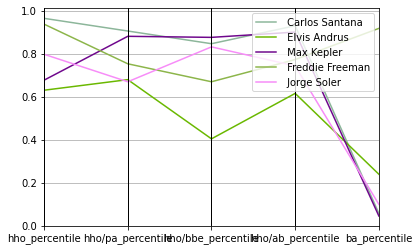

In [75]:
#parallel_coordinates(df[['batter_name', 'hh_percentile','hho_percentile', 'hho/pa_percentile', 'hho/bbe_percentile', 'hho/ab_percentile', 'ba_percentile']],"batter_name")

In [58]:
# Reference Code I don't want to lose
#fig = go.Figure(data=
   # go.Parcoords(
     #   dimensions = list([
       #     dict(range = [0,20],
        #        label = 'HHO', values = df1['hho_rank']),
           # dict(range = [0,20],
            #    label = 'HHO/PA', values = df1['hho/pa_rank']),
           # dict(range = [0,20],
            #    label = 'HHO/BBE', values = df1['hho/bbe_rank']),
           # dict(range = [0,20],
            #    label = 'HHO/AB', values = df1['hho/ab_rank'])
    #    ])
    # )
 # )

# fig

In [59]:
# xBA chart for Datawrapper
xba_chart = df.sort_values('ba_dif').head(10)

In [60]:
xba_chart.to_csv('xba_chart.csv')

In [61]:
# xSLG chart for Datawrapper
xslg_chart = df.sort_values('slg_dif').head(10)

In [62]:
xslg_chart.to_csv('xslg_chart.csv')

In [63]:
# xwOBA chart for Datawrapper
woba_chart = df.sort_values('woba_dif').head(10)

In [64]:
woba_chart.to_csv('woba_chart.csv')

In [77]:
woba_chart

,batter_name,hho,bbe,hho/bbe,barrels,brl_percent,brl_pa,hh,hh/bbe,ab,hho/pa,pa,ba,est_ba,ba_dif,slg,est_slg,slg_dif,woba,est_woba,woba_dif,hho/hh,hho/ab,barrels/ab,hho_rank,hho/pa_rank,hho/bbe_rank,hho/ab_rank,hho_percentile,hho/pa_percentile,hho/bbe_percentile,hho/ab_percentile,brl_percentile,hh_percentile,ba_percentile
54,Carlos Santana,114,468,24.358974,32,6.8,4.9,196,41.9,566,17.298938,659,0.214,0.244,-0.030,0.342,0.421,-0.079,0.294,0.335,-0.041,58.163265,20.141343,5.653710,8.0,20.0,32.0,15.0,0.965517,0.906404,0.847291,0.931034,0.352217,0.546798,0.056650
193,Elvis Andrus,81,423,19.148936,9,2.1,1.7,147,34.8,497,14.972274,541,0.243,0.273,-0.030,0.320,0.375,-0.055,0.270,0.308,-0.038,55.102041,16.297787,1.810865,76.0,66.0,122.0,79.0,0.630542,0.679803,0.403941,0.615764,0.051724,0.209360,0.238916
56,Max Kepler,83,334,24.850299,36,10.8,7.3,142,42.5,426,16.938776,490,0.211,0.255,-0.044,0.413,0.452,-0.039,0.309,0.347,-0.038,58.450704,19.483568,8.450704,66.5,25.0,26.0,21.0,0.677340,0.881773,0.876847,0.901478,0.721675,0.610837,0.044335
11,Freddie Freeman,107,495,21.616162,57,11.5,8.2,228,46.1,600,15.395683,695,0.300,0.320,-0.020,0.503,0.583,-0.080,0.379,0.416,-0.037,46.929825,17.833333,9.500000,13.5,51.0,68.0,47.0,0.938424,0.753695,0.669951,0.773399,0.785714,0.768473,0.918719
5,Jorge Soler,90,379,23.746702,48,12.7,8.0,178,47.0,516,14.950166,602,0.223,0.250,-0.027,0.432,0.494,-0.062,0.323,0.359,-0.036,50.561798,17.441860,9.302326,42.0,68.0,35.0,53.0,0.798030,0.669951,0.832512,0.743842,0.834975,0.800493,0.098522
91,Tommy Pham,89,351,25.356125,35,10.0,6.2,167,47.6,475,15.864528,561,0.229,0.258,-0.029,0.383,0.443,-0.060,0.318,0.354,-0.036,53.293413,18.736842,7.368421,46.5,39.0,15.0,27.0,0.775862,0.812808,0.931034,0.871921,0.655172,0.844828,0.133005
57,Josh Donaldson,100,351,28.490028,61,17.4,11.2,185,52.7,457,18.416206,543,0.247,0.269,-0.022,0.475,0.542,-0.067,0.353,0.388,-0.035,54.054054,21.881838,13.347921,23.5,8.0,1.0,4.0,0.889163,0.965517,1.000000,0.985222,0.955665,0.953202,0.283251
6,Dominic Smith,70,340,20.588235,22,6.5,4.5,138,40.7,446,14.198783,493,0.244,0.262,-0.018,0.363,0.420,-0.057,0.291,0.325,-0.034,50.724638,15.695067,4.932735,112.0,87.0,97.0,97.0,0.453202,0.576355,0.527094,0.527094,0.322660,0.470443,0.251232
42,Yan Gomes,55,272,20.220588,24,8.8,6.4,104,38.2,349,14.666667,375,0.252,0.280,-0.028,0.421,0.469,-0.048,0.308,0.341,-0.033,52.884615,15.759312,6.876791,167.0,81.0,100.0,92.0,0.182266,0.605911,0.512315,0.551724,0.549261,0.332512,0.352217
194,Jed Lowrie,82,353,23.229462,33,9.3,6.4,162,45.9,458,16.015625,512,0.245,0.259,-0.014,0.398,0.464,-0.066,0.311,0.343,-0.032,50.617284,17.903930,7.205240,71.0,36.0,40.0,43.0,0.655172,0.827586,0.807882,0.793103,0.605911,0.763547,0.261084


In [80]:
df.sort_values('hho', ascending=False).head(10)

,batter_name,hho,bbe,hho/bbe,barrels,brl_percent,brl_pa,hh,hh/bbe,ab,hho/pa,pa,ba,est_ba,ba_dif,slg,est_slg,slg_dif,woba,est_woba,woba_dif,hho/hh,hho/ab,barrels/ab,hho_rank,hho/pa_rank,hho/bbe_rank,hho/ab_rank,hho_percentile,hho/pa_percentile,hho/bbe_percentile,hho/ab_percentile,brl_percentile,hh_percentile,ba_percentile
89,Manny Machado,134,473,28.329810,63,13.3,9.8,247,52.2,564,20.937500,640,0.278,0.295,-0.017,0.489,0.531,-0.042,0.350,0.380,-0.030,54.251012,23.758865,11.170213,1.0,1.0,2.0,1.0,1.000000,1.000000,0.995074,1.000000,0.847291,0.935961,0.770936
141,Vladimir Guerrero Jr.,127,496,25.604839,75,15.1,10.7,274,55.2,604,18.194842,698,0.311,0.307,0.004,0.601,0.594,0.007,0.419,0.418,0.001,46.350365,21.026490,12.417219,2.0,11.0,13.0,7.0,0.995074,0.950739,0.940887,0.970443,0.911330,0.975369,0.977833
45,Matt Olson,125,463,26.997840,59,12.7,8.8,226,48.8,565,18.573551,673,0.271,0.264,0.007,0.540,0.507,0.033,0.379,0.378,0.001,55.309735,22.123894,10.442478,3.5,6.0,6.0,2.0,0.987685,0.975369,0.975369,0.995074,0.834975,0.874384,0.692118
189,DJ LeMahieu,125,508,24.606299,19,3.7,2.8,220,43.5,597,18.409426,679,0.268,0.283,-0.015,0.362,0.397,-0.035,0.315,0.340,-0.025,56.818182,20.938023,3.182580,3.5,9.0,30.0,8.0,0.987685,0.960591,0.857143,0.965517,0.137931,0.687192,0.642857
58,Salvador Perez,121,454,26.651982,74,16.3,11.1,255,56.2,620,18.195489,665,0.273,0.276,-0.003,0.544,0.565,-0.021,0.359,0.374,-0.015,47.450980,19.516129,11.935484,5.0,10.0,7.0,20.0,0.980296,0.955665,0.970443,0.906404,0.935961,0.990148,0.721675
120,Paul Goldschmidt,118,472,25.000000,64,13.6,9.4,239,50.6,604,17.378498,679,0.294,0.293,0.001,0.514,0.575,-0.061,0.373,0.397,-0.024,49.372385,19.536424,10.596026,6.0,19.0,20.5,19.0,0.975369,0.911330,0.903941,0.911330,0.864532,0.916256,0.881773
140,Bo Bichette,115,507,22.682446,50,9.9,7.2,241,47.5,640,16.666667,690,0.298,0.291,0.007,0.484,0.490,-0.006,0.354,0.355,-0.001,47.717842,17.968750,7.812500,7.0,27.0,52.0,41.0,0.970443,0.871921,0.748768,0.802956,0.647783,0.834975,0.908867
54,Carlos Santana,114,468,24.358974,32,6.8,4.9,196,41.9,566,17.298938,659,0.214,0.244,-0.030,0.342,0.421,-0.079,0.294,0.335,-0.041,58.163265,20.141343,5.653710,8.0,20.0,32.0,15.0,0.965517,0.906404,0.847291,0.931034,0.352217,0.546798,0.056650
155,Rafael Devers,112,452,24.778761,68,15.0,10.2,234,51.8,591,16.867470,664,0.279,0.291,-0.012,0.538,0.567,-0.029,0.373,0.394,-0.021,47.863248,18.950931,11.505922,9.5,26.0,28.0,25.0,0.958128,0.876847,0.866995,0.881773,0.903941,0.921182,0.790640
99,Aaron Judge,112,397,28.211587,70,17.6,11.1,230,58.4,550,17.693523,633,0.287,0.308,-0.021,0.544,0.594,-0.050,0.387,0.418,-0.031,48.695652,20.363636,12.727273,9.5,15.0,3.0,11.0,0.958128,0.931034,0.990148,0.950739,0.965517,1.000000,0.847291


In [82]:
df.sort_values('hh/bbe', ascending=False).head(10)

,batter_name,hho,bbe,hho/bbe,barrels,brl_percent,brl_pa,hh,hh/bbe,ab,hho/pa,pa,ba,est_ba,ba_dif,slg,est_slg,slg_dif,woba,est_woba,woba_dif,hho/hh,hho/ab,barrels/ab,hho_rank,hho/pa_rank,hho/bbe_rank,hho/ab_rank,hho_percentile,hho/pa_percentile,hho/bbe_percentile,hho/ab_percentile,brl_percentile,hh_percentile,ba_percentile
99,Aaron Judge,112,397,28.211587,70,17.6,11.1,230,58.4,550,17.693523,633,0.287,0.308,-0.021,0.544,0.594,-0.050,0.387,0.418,-0.031,48.695652,20.363636,12.727273,9.5,15.0,3.0,11.0,0.958128,0.931034,0.990148,0.950739,0.965517,1.000000,0.847291
111,Giancarlo Stanton,89,356,25.000000,56,15.7,9.7,198,56.3,510,15.371330,579,0.273,0.262,0.011,0.516,0.498,0.018,0.370,0.363,0.007,44.949495,17.450980,10.980392,46.5,53.0,20.5,52.0,0.775862,0.743842,0.903941,0.748768,0.916256,0.995074,0.721675
58,Salvador Perez,121,454,26.651982,74,16.3,11.1,255,56.2,620,18.195489,665,0.273,0.276,-0.003,0.544,0.565,-0.021,0.359,0.374,-0.015,47.450980,19.516129,11.935484,5.0,10.0,7.0,20.0,0.980296,0.955665,0.970443,0.906404,0.935961,0.990148,0.721675
55,Miguel Sanó,74,288,25.694444,51,17.7,9.6,161,55.9,470,13.909774,532,0.223,0.216,0.007,0.466,0.439,0.027,0.332,0.322,0.010,45.962733,15.744681,10.851064,103.0,97.0,12.0,94.0,0.497537,0.527094,0.945813,0.541872,0.970443,0.985222,0.098522
90,Fernando Tatis Jr.,86,329,26.139818,70,21.3,12.8,183,55.6,478,15.750916,546,0.282,0.279,0.003,0.611,0.617,-0.006,0.403,0.407,-0.004,46.994536,17.991632,14.644351,56.0,41.0,10.0,39.0,0.729064,0.802956,0.955665,0.812808,0.995074,0.980296,0.815271
141,Vladimir Guerrero Jr.,127,496,25.604839,75,15.1,10.7,274,55.2,604,18.194842,698,0.311,0.307,0.004,0.601,0.594,0.007,0.419,0.418,0.001,46.350365,21.026490,12.417219,2.0,11.0,13.0,7.0,0.995074,0.950739,0.940887,0.970443,0.911330,0.975369,0.977833
40,Yordan Alvarez,105,395,26.582278,63,15.9,10.5,214,54.2,537,17.558528,598,0.277,0.279,-0.002,0.531,0.570,-0.039,0.369,0.389,-0.020,49.065421,19.553073,11.731844,18.0,17.0,8.0,18.0,0.916256,0.921182,0.965517,0.916256,0.921182,0.970443,0.753695
128,Shohei Ohtani,87,350,24.857143,78,22.3,12.2,187,53.6,537,13.615023,639,0.257,0.269,-0.012,0.592,0.616,-0.024,0.393,0.411,-0.018,46.524064,16.201117,14.525140,53.5,106.0,25.0,80.0,0.741379,0.482759,0.881773,0.610837,1.000000,0.965517,0.431034
94,Joey Votto,82,325,25.230769,56,17.2,10.5,173,53.2,448,15.384615,533,0.266,0.274,-0.008,0.563,0.592,-0.029,0.391,0.406,-0.015,47.398844,18.303571,12.500000,71.0,52.0,18.0,33.0,0.655172,0.748768,0.916256,0.842365,0.950739,0.960591,0.603448
57,Josh Donaldson,100,351,28.490028,61,17.4,11.2,185,52.7,457,18.416206,543,0.247,0.269,-0.022,0.475,0.542,-0.067,0.353,0.388,-0.035,54.054054,21.881838,13.347921,23.5,8.0,1.0,4.0,0.889163,0.965517,1.000000,0.985222,0.955665,0.953202,0.283251
